# TorchVision Instance Segmentation Finetuning



In [2]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-s2p0gy_s
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-s2p0gy_s
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Displaying an image of the database

In [6]:
from PIL import Image
Image.open('/content/gdrive/Shareddrives/Machine_Vision_Group_4/MinneApple_Datasets/detection/train/images/20150919_174151_image1.png')

Output hidden; open in https://colab.research.google.com to view.

##Displaying of the associated mask


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]


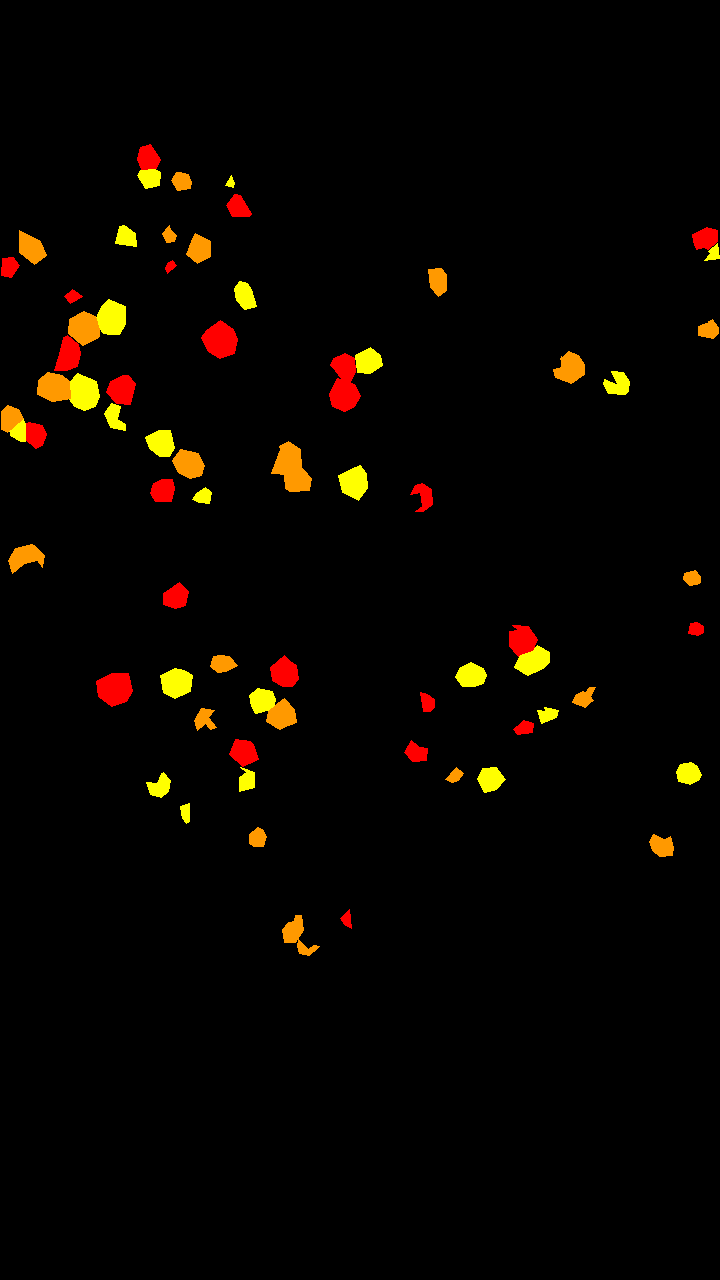

In [7]:
import numpy as np



mask = Image.open('/content/gdrive/Shareddrives/Machine_Vision_Group_4/MinneApple_Datasets/detection/train/masks/20150919_174151_image1.png')

# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.

mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])

obj_ids = np.unique(mask)

print(obj_ids)



mask



##Creating the database class for the training

So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let's write a `torch.utils.data.Dataset` class for this dataset.

In [8]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "/content/gdrive/Shareddrives/Machine_Vision_Group_4/MinneApple_Datasets/detection/train/images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "/content/gdrive/Shareddrives/Machine_Vision_Group_4/MinneApple_Datasets/detection/train/masks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "/content/gdrive/Shareddrives/Machine_Vision_Group_4/MinneApple_Datasets/detection/train/images", self.imgs[idx])
        mask_path = os.path.join(self.root, "/content/gdrive/Shareddrives/Machine_Vision_Group_4/MinneApple_Datasets/detection/train/masks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [9]:
dataset = PennFudanDataset('PennFudanPed/')

#Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())



In [10]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [11]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 277129, done.
remote: Counting objects: 100% (16330/16330), done.
remote: Compressing objects: 100% (795/795), done.
remote: Total 277129 (delta 15580), reused 16213 (delta 15503), pack-reused 260799
Receiving objects: 100% (277129/277129), 554.42 MiB | 38.59 MiB/s, done.
Resolving deltas: 100% (253349/253349), done.
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [12]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Testing forward() method 

Before iterating over the dataset, it’s good to see what the model expects during training and inference time on sample data.


In [13]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions



/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [14]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

And now let's train the model for 50 epochs, evaluating at the end of every epoch.

> Bloc en retrait



In [1]:
# let's train it for 50 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 50

for epoch in range(num_epochs):
    # train for one epoch, printing every 50 iterations
    try :
      train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=310)
      # update the learning rate
      lr_scheduler.step()
      # evaluate on the test dataset
      evaluate(model, data_loader_test, device=device)
    except:
      None

Now that training has finished, let's have a look at what it actually predicts in a test image

In [ ]:
torch.save(model, 'mask-rcnn-apples-50.pt') #We save it for latter

In [ ]:
# pick one image from the test set

model = torch.load('/content/gdrive/Shareddrives/Machine_Vision_Group_4/Machine Learning/Previous Work/mask-rcnn-apples-50.pt')


img, _ = dataset_test[0]

# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [ ]:
dataset_test[1]

(tensor([[[0.1020, 0.1020, 0.1098,  ..., 0.4353, 0.4353, 0.4353],
          [0.1020, 0.1020, 0.1098,  ..., 0.4353, 0.4353, 0.4353],
          [0.1020, 0.1020, 0.1098,  ..., 0.4353, 0.4353, 0.4353],
          ...,
          [0.0314, 0.0314, 0.0314,  ..., 0.1294, 0.1255, 0.1255],
          [0.0314, 0.0314, 0.0314,  ..., 0.0824, 0.0902, 0.0902],
          [0.0314, 0.0314, 0.0314,  ..., 0.0667, 0.0745, 0.0745]],
 
         [[0.1765, 0.1765, 0.1843,  ..., 0.6431, 0.6431, 0.6431],
          [0.1765, 0.1765, 0.1843,  ..., 0.6431, 0.6431, 0.6431],
          [0.1765, 0.1765, 0.1843,  ..., 0.6431, 0.6431, 0.6431],
          ...,
          [0.0353, 0.0353, 0.0353,  ..., 0.1216, 0.1176, 0.1176],
          [0.0353, 0.0353, 0.0353,  ..., 0.0745, 0.0824, 0.0824],
          [0.0353, 0.0353, 0.0353,  ..., 0.0588, 0.0667, 0.0667]],
 
         [[0.3608, 0.3608, 0.3686,  ..., 0.9490, 0.9490, 0.9490],
          [0.3608, 0.3608, 0.3686,  ..., 0.9490, 0.9490, 0.9490],
          [0.3608, 0.3608, 0.3686,  ...,

In [ ]:
prediction

[{'boxes': tensor([[6.7135e+02, 4.8431e+01, 7.0905e+02, 8.9258e+01],
          [5.5331e+02, 2.5112e+02, 5.8903e+02, 2.8607e+02],
          [1.8837e+02, 2.9443e+02, 2.1759e+02, 3.2965e+02],
          [6.7283e+02, 3.8243e+02, 7.1189e+02, 4.1477e+02],
          [6.7108e+02, 2.9268e+02, 7.0707e+02, 3.3140e+02],
          [6.0389e+02, 1.9284e+02, 6.3410e+02, 2.2526e+02],
          [2.8146e+01, 1.1752e+02, 6.6447e+01, 1.5758e+02],
          [1.8137e-02, 1.4398e+02, 4.0173e+01, 1.7654e+02],
          [5.6943e+02, 3.0518e+02, 6.0935e+02, 3.4258e+02],
          [6.9564e+02, 5.9225e+02, 7.1993e+02, 6.2486e+02],
          [6.4065e+02, 3.0245e+02, 6.7416e+02, 3.3855e+02],
          [5.7640e+02, 7.0602e+02, 6.0736e+02, 7.3851e+02],
          [5.6414e+02, 5.9415e+02, 6.0218e+02, 6.1983e+02],
          [5.5453e+02, 4.0809e+02, 5.9522e+02, 4.4666e+02],
          [2.3680e+01, 1.8520e+02, 5.8881e+01, 2.1313e+02],
          [1.1964e+00, 1.1050e+02, 2.5256e+01, 1.3639e+02],
          [1.7116e+02, 2.0711e+

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

Output hidden; open in https://colab.research.google.com to view.

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

In [ ]:
A = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()

for k in range(len(prediction[0]['scores'])):
  A = A + prediction[0]['masks'][k, 0].mul(255).byte().cpu().numpy()


A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
from IPython.core import error
import matplotlib.pyplot as plt

model = torch.load('/content/gdrive/Shareddrives/Machine_Vision_Group_4/Machine Learning/Previous Work/mask-rcnn-apples-50.pt')
# put the model in evaluation mode
model.eval()

def test_apples(photo_index, error):
  number_of_apples_in_theory = len(dataset_test[photo_index][1]['masks'])
  # pick one image from the test set
  img, _ = dataset_test[photo_index]
  
  with torch.no_grad():
      prediction = model([img.to(device)])

  scores = prediction[0]['scores'].tolist()
  number_of_apples_predictions = 0

  for k in range(len(scores)):
    if scores[k] > error:
      number_of_apples_predictions +=1




  A = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()

  for k in range(len(prediction[0]['scores'])):
    A = A + prediction[0]['masks'][k, 0].mul(255).byte().cpu().numpy()

  fig, ax = plt.subplots(1,2)
  plt.rcParams['figure.figsize'] = [10, 5]
  ax[0].imshow(Image.fromarray(A));
  ax[1].imshow(Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy()));

  return abs(number_of_apples_predictions - number_of_apples_in_theory)/number_of_apples_in_theory



print(test_apples(10,0.6))


"""

for i in error_threshold:
  print(i)
  for j in range(48):
    B = B + test_apples(j, i)
  error_List.append(B/48)




plt.plot(error_threshold,error_List)
plt.show()




A = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()

for k in range(len(prediction[0]['scores'])):
  A = A + prediction[0]['masks'][k, 0].mul(255).byte().cpu().numpy()

fig, ax = plt.subplots(1,2)
plt.rcParams['figure.figsize'] = [10, 5]
ax[0].imshow(Image.fromarray(A));
ax[1].imshow(Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy()));

"""




KeyError: ignored

### This part aims to test the code with a common database for all methods used for detection.

In [ ]:
class Validation_dataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "/content/gdrive/Shareddrives/Machine_Vision_Group_4/MinneApple_Datasets/Comparison_test_dataset/test/images"))))
        
    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "/content/gdrive/Shareddrives/Machine_Vision_Group_4/MinneApple_Datasets/Comparison_test_dataset/test/images", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        
      
        image_id = torch.tensor([idx])
        target = {}      
        target["image_id"] = image_id
        target["image_path"] = img_path
 

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
dataset_validation = Validation_dataset('test/', get_transform(train=False))
dataset_validation[0]

(tensor([[[0.3294, 0.3373, 0.3373,  ..., 0.4980, 0.5373, 0.6235],
          [0.2941, 0.2706, 0.2863,  ..., 0.4902, 0.5569, 0.6588],
          [0.3686, 0.3765, 0.3804,  ..., 0.4941, 0.5569, 0.6549],
          ...,
          [0.0235, 0.0078, 0.0000,  ..., 0.0549, 0.0588, 0.0588],
          [0.0314, 0.0275, 0.0235,  ..., 0.0549, 0.0549, 0.0549],
          [0.0000, 0.0078, 0.0118,  ..., 0.0510, 0.0549, 0.0549]],
 
         [[0.2157, 0.2196, 0.2275,  ..., 0.5098, 0.5529, 0.6392],
          [0.1804, 0.1569, 0.1765,  ..., 0.5059, 0.5725, 0.6745],
          [0.2588, 0.2667, 0.2706,  ..., 0.5098, 0.5725, 0.6706],
          ...,
          [0.0627, 0.0471, 0.0314,  ..., 0.0667, 0.0706, 0.0706],
          [0.0706, 0.0667, 0.0627,  ..., 0.0667, 0.0667, 0.0667],
          [0.0353, 0.0471, 0.0510,  ..., 0.0627, 0.0667, 0.0667]],
 
         [[0.0588, 0.0706, 0.0824,  ..., 0.5294, 0.5647, 0.6431],
          [0.0157, 0.0000, 0.0196,  ..., 0.5176, 0.5765, 0.6784],
          [0.0706, 0.0784, 0.0824,  ...,

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from google.colab.patches import cv2_imshow
import os
from scipy import ndimage # multidimensional image processing
from skimage.color import rgb2hsv # image processing algorithms
from skimage.feature import local_binary_pattern

# create an empty array of the desired shape and data type
#test_images = np.empty([10, 1280, 720, 3], dtype=np.uint8)
test_images=[]
# make some fake label values as an example
test_labels = []
# convert this 1D array to 2D array
# test_labels = np.expand_dims(test_labels, axis=1)

data_path = '/content/gdrive/Shareddrives/Machine_Vision_Group_4/MinneApple_Datasets/Comparison_test_dataset/test_combined/'

dataset = list(os.listdir(data_path))          
dataset.sort()
print(dataset)
# there are 32 images in our validation that dataset

for i in range(32):
  # Now order is sorted, we just want to take the even ones 0,2,4 As these are the png images.
  img_name = data_path  + dataset[2*i]
  # the odd ones are the corresponding labels
  img_label = data_path + dataset [2*i + 1]
  #test_images[i, :, :, :] = plt.imread(img_name)
  test_images.append(img_name)
  test_labels.append(img_label)


model = torch.load('/content/gdrive/Shareddrives/Machine_Vision_Group_4/Machine Learning/Previous Work/mask-rcnn-apples-50.pt')
# put the model in evaluation mode
model.eval()

label = open(test_labels[i])
NumberOfApples = len(label.readlines())

def test_apples(photo_index, error):
  img, _ = dataset_validation[photo_index]
  with torch.no_grad():
      prediction = model([img.to(device)])
  scores = prediction[0]['scores'].tolist()
  number_of_apples_predictions = 0
  for k in range(len(scores)):
    if scores[k] > error:
      number_of_apples_predictions +=1

  label = open(test_labels[i])
  NumberOfApples = len(label.readlines())

  
  print( str(number_of_apples_predictions) + ';')
  print(str(NumberOfApples) + " , Apples are labelled")
  print(str(round(number_of_apples_predictions/NumberOfApples,3)*100) + "% of apples have been detected")
  print("\n")
  
  return round(number_of_apples_predictions/NumberOfApples,3)*100


Resultats = 0
for i in range(32):
  Resultats += test_apples(i,0.25)

print(Resultats/32)
  
  

['dataset1_back_1081_png.rf.61ad8a45c7a6cfefce41e0ae4aa209f1.jpg', 'dataset1_back_1081_png.rf.61ad8a45c7a6cfefce41e0ae4aa209f1.txt', 'dataset1_back_1141_png.rf.0216021bb8e9179983fb45da0c6fa934.jpg', 'dataset1_back_1141_png.rf.0216021bb8e9179983fb45da0c6fa934.txt', 'dataset1_back_301_png.rf.ab9701d9c6a849627fce81f64d5105c7.jpg', 'dataset1_back_301_png.rf.ab9701d9c6a849627fce81f64d5105c7.txt', 'dataset1_back_991_png.rf.5626aedb831e06350ffdb6b3e8f01569.jpg', 'dataset1_back_991_png.rf.5626aedb831e06350ffdb6b3e8f01569.txt', 'dataset1_front_1231_png.rf.50e9ade8b5194fc33cb22710d3cb6600.jpg', 'dataset1_front_1231_png.rf.50e9ade8b5194fc33cb22710d3cb6600.txt', 'dataset2_back_0_png.rf.949e54161af4910b29e8db97aa217849.jpg', 'dataset2_back_0_png.rf.949e54161af4910b29e8db97aa217849.txt', 'dataset2_back_1380_png.rf.6fb9d41e2c12bd152d44c9b1a7bbf721.jpg', 'dataset2_back_1380_png.rf.6fb9d41e2c12bd152d44c9b1a7bbf721.txt', 'dataset2_back_330_png.rf.c0d1a804fed0a719329327477d324210.jpg', 'dataset2_back_330

# This part aims at showing an image with the predicted masks


(640, 640, 3)
(640, 640, 3)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


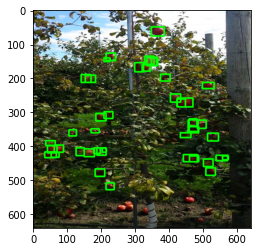

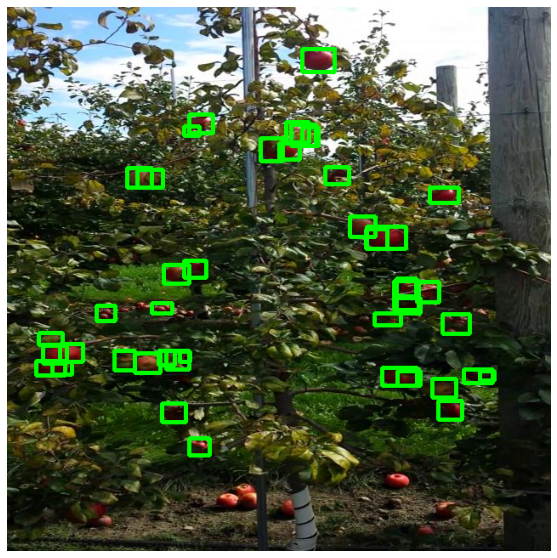

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from google.colab.patches import cv2_imshow
import os
from scipy import ndimage # multidimensional image processing
from skimage.color import rgb2hsv # image processing algorithms
from skimage.feature import local_binary_pattern

# create an empty array of the desired shape and data type
#test_images = np.empty([10, 1280, 720, 3], dtype=np.uint8)
test_images=[]
# make some fake label values as an example
test_labels = []
# convert this 1D array to 2D array
# test_labels = np.expand_dims(test_labels, axis=1)

data_path = '/content/gdrive/Shareddrives/Machine_Vision_Group_4/MinneApple_Datasets/Comparison_test_dataset/test_combined/'

dataset = list(os.listdir(data_path))          
dataset.sort()

# there are 32 images in our validation that dataset

for i in range(32):
  # Now order is sorted, we just want to take the even ones 0,2,4 As these are the png images.
  img_name = data_path  + dataset[2*i]
  # the odd ones are the corresponding labels
  img_label = data_path + dataset [2*i + 1]
  #test_images[i, :, :, :] = plt.imread(img_name)
  test_images.append(img_name)
  test_labels.append(img_label)
  if 'dataset1_back_1181' in test_labels[i]:
    print(i)


model = torch.load('/content/gdrive/Shareddrives/Machine_Vision_Group_4/Machine Learning/Previous Work/mask-rcnn-apples-50.pt')
# put the model in evaluation mode
model.eval()


img, _ = dataset_validation[0]
with torch.no_grad():
    prediction = model([img.to(device)])

boxes = prediction[0]['boxes'].tolist()
masks = prediction[0]['masks']
img_path = dataset_validation[0][1]['image_path']





import random

def random_color_masks(masks):
  l,m,n = masks.shape
  A = np.zeros((m,n,3))
  
  for i in range(m):
    for j in range(n):
      if masks[0][i][j] > 10:
        A[i][j][0] = 255
        A[i][j][1] = 0
        A[i][j][2] = 0
  return A
  
    

rect_th=3


rgb_mask = random_color_masks(prediction[0]['masks'][0].cpu().numpy())

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # For working with RGB images instead of BGR

print(rgb_mask.shape)
print(img.shape)
print(type(rgb_mask))
print(type(img))

for i in range(len(masks)):
    #rgb_mask = random_color_masks(prediction[0]['masks'][i].cpu().numpy())
    #img = cv2.addWeighted(img, 1, np.asarray(rgb_mask, np.float64), 0.5, 0)
    pt1 = (int(boxes[i][0]),int(boxes[i][1]))
    pt2 = (int(boxes[i][2]),int(boxes[i][3]))
    cv2.rectangle(img, pt1, pt2, color=(0, 255, 0), thickness=rect_th)

plt.imshow(img)

# plotting a line plot after changing it's width and height
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
plt.axis('off')
  
plt.imshow(img)
